In [2]:
import sys
sys.path.append("src")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from constants import daily_installs
from retention_models import exp, power, log, inv
from modeling import fit_and_score_models, plot_retention_curves


In [3]:
x = np.array([1, 3, 7, 14])
yA = np.array([0.53, 0.27, 0.17, 0.06])
yB = np.array([0.48, 0.25, 0.19, 0.09])

models = [
    ("Power Law", power, (0, [1, 5])),
    ("Logarithmic", log, (0, [1, 1])),
    ("Inverse", inv, (0, [1, 10])),
    ("Exponential", exp, (0, 1))
]


In [4]:
summary, params_dict = fit_and_score_models(models, x, yA, yB, daily_installs)
display(summary)


,Model,R² A,R² B,Avg R²,DAU A,DAU B
0,Power Law,0.985,0.984,0.985,54685,56474
1,Logarithmic,0.977,0.960,0.969,54256,56981
2,Inverse,0.983,0.940,0.961,49216,46939
3,Exponential,0.952,0.901,0.926,50011,54454


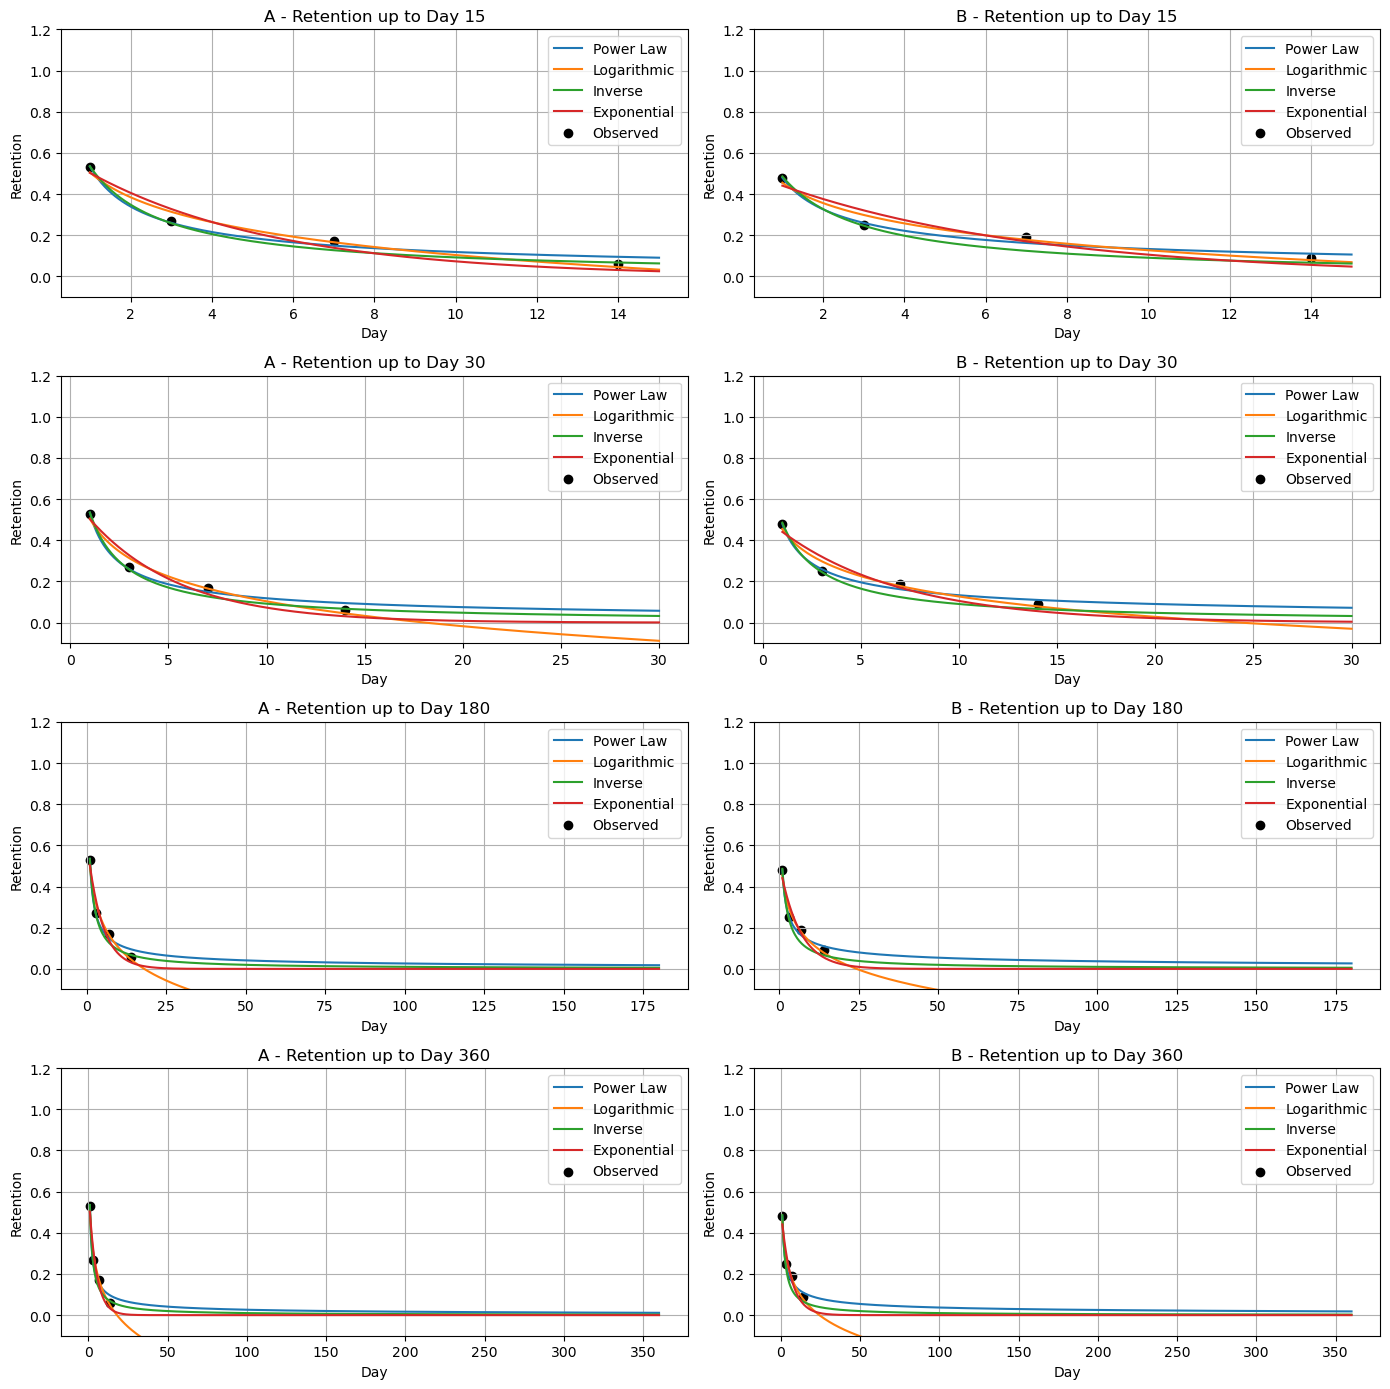

In [5]:
plot_retention_curves(params_dict, x, yA, yB)

In [6]:
from simulation import simulate_dau

# Extract exponential model and parameters
exp_model = params_dict["Exponential"]["func"]
pa = params_dict["Exponential"]["A"]
pb = params_dict["Exponential"]["B"]

days = 15  # horizon for ARPPU calculation

# Simulate DAU using exponential model
dau_A = simulate_dau(days, pa, daily_installs, exp_model)
dau_B = simulate_dau(days, pb, daily_installs, exp_model)


In [7]:
from constants import (
    purchase_rate_A, purchase_rate_B,
    impressions_per_dau_A, impressions_per_dau_B,
    ecpm_A, ecpm_B
)

# Calculate ad revenue
ad_rev_A = sum([d * impressions_per_dau_A * ecpm_A / 1000 for d in dau_A])
ad_rev_B = sum([d * impressions_per_dau_B * ecpm_B / 1000 for d in dau_B])

# Calculate IAP units
iap_units_A = sum([d * purchase_rate_A for d in dau_A])
iap_units_B = sum([d * purchase_rate_B for d in dau_B])

# Solve for break-even ARPPU
numerator = ad_rev_B - ad_rev_A
denominator = iap_units_A - iap_units_B

if abs(denominator) < 1e-6:
    critical_arppu = None
    print("Cant compute critical ARPPU - denominator close to 0")
else:
    critical_arppu = numerator / denominator
    print(f"Critical ARPPU: {critical_arppu:.2f} USD")


✅ Critical ARPPU: 3.05 USD


In [8]:
arppu_values = np.linspace(1.0, 5.0, 9)  # 1.0 to 5.0 in 0.5 steps
rows = []

for arppu in arppu_values:
    iap_rev_A = arppu * iap_units_A
    iap_rev_B = arppu * iap_units_B
    total_A = ad_rev_A + iap_rev_A
    total_B = ad_rev_B + iap_rev_B

    winner = (
        "Tie" if np.isclose(total_A, total_B, atol=1e-2)
        else "A" if total_A > total_B
        else "B"
    )

    rows.append([
        round(arppu, 2),
        round(ad_rev_A, 2), round(ad_rev_B, 2),
        round(iap_rev_A, 2), round(iap_rev_B, 2),
        round(total_A, 2), round(total_B, 2),
        winner
    ])

arppu_comp_df = pd.DataFrame(rows, columns=[
    "ARPPU",
    "Ad Revenue A", "Ad Revenue B",
    "IAP Revenue A", "IAP Revenue B",
    "Total Revenue A", "Total Revenue B",
    "Winner"
])

display(arppu_comp_df)


,ARPPU,Ad Revenue A,Ad Revenue B,IAP Revenue A,IAP Revenue B,Total Revenue A,Total Revenue B,Winner
0,1.0,12903.15,10084.8,17459.89,18383.74,30363.04,28468.54,A
1,1.5,12903.15,10084.8,26189.84,27575.61,39092.99,37660.41,A
2,2.0,12903.15,10084.8,34919.79,36767.48,47822.93,46852.28,A
3,2.5,12903.15,10084.8,43649.73,45959.35,56552.88,56044.15,A
4,3.0,12903.15,10084.8,52379.68,55151.22,65282.83,65236.02,A
5,3.5,12903.15,10084.8,61109.63,64343.10,74012.77,74427.89,B
6,4.0,12903.15,10084.8,69839.57,73534.97,82742.72,83619.76,B
7,4.5,12903.15,10084.8,78569.52,82726.84,91472.67,92811.63,B
8,5.0,12903.15,10084.8,87299.47,91918.71,100202.61,102003.50,B


In [23]:
# Use ARPPU value from constants
from constants import arppu

#  Revenue for 15 Day (Task 1b)
ad_rev_A_15, iap_rev_A_15, total_A_15 = calc_revenue(
    dau_A, purchase_rate_A, impressions_per_dau_A, ecpm_A, arppu)

ad_rev_B_15, iap_rev_B_15, total_B_15 = calc_revenue(
    dau_B, purchase_rate_B, impressions_per_dau_B, ecpm_B, arppu)

#  Revenue for 30 Day (Task 1c)
ad_rev_A_30, iap_rev_A_30, total_A_30 = calc_revenue(
    dau_A, purchase_rate_A, impressions_per_dau_A, ecpm_A, arppu)

ad_rev_B_30, iap_rev_B_30, total_B_30 = calc_revenue(
    dau_B, purchase_rate_B, impressions_per_dau_B, ecpm_B, arppu)

print(f"15-Day Total Revenue (ARPPU = ${arppu}):")
print(f"Variant A: Ad = ${ad_rev_A_15:.2f}, IAP = ${iap_rev_A_15:.2f}, Total = ${total_A_15:.2f}")
print(f"Variant B: Ad = ${ad_rev_B_15:.2f}, IAP = ${iap_rev_B_15:.2f}, Total = ${total_B_15:.2f}")

print(f"\n30-Day Total Revenue (ARPPU = ${arppu}):")
print(f"Variant A: Ad = ${ad_rev_A_30:.2f}, IAP = ${iap_rev_A_30:.2f}, Total = ${total_A_30:.2f}")
print(f"Variant B: Ad = ${ad_rev_B_30:.2f}, IAP = ${iap_rev_B_30:.2f}, Total = ${total_B_30:.2f}")


15-Day Total Revenue (ARPPU = $5.0):
Variant A: Ad = $12903.15, IAP = $87299.47, Total = $100202.61
Variant B: Ad = $10084.80, IAP = $91918.71, Total = $102003.50

30-Day Total Revenue (ARPPU = $5.0):
Variant A: Ad = $12903.15, IAP = $87299.47, Total = $100202.61
Variant B: Ad = $10084.80, IAP = $91918.71, Total = $102003.50


In [25]:
# Sale parameters
sale_start = 15
sale_end = 24
boost = 0.01

# Revenue function with time-varying purchase rate
def calc_revenue_with_sale(dau, base_purchase_rate, impressions_per_dau, ecpm, arppu, sale_start, sale_end, boost):
    ad_rev = 0
    iap_rev = 0

    for day, users in enumerate(dau, start=1):
        purchase_rate = base_purchase_rate + boost if sale_start <= day <= sale_end else base_purchase_rate
        ad_rev += users * impressions_per_dau * ecpm / 1000
        iap_rev += users * purchase_rate * arppu

    return ad_rev, iap_rev, ad_rev + iap_rev

# Using 30 day DAUs
ad_rev_A_sale, iap_rev_A_sale, total_A_sale = calc_revenue_with_sale(
    dau_A_30, purchase_rate_A, impressions_per_dau_A, ecpm_A, arppu, sale_start, sale_end, boost)

ad_rev_B_sale, iap_rev_B_sale, total_B_sale = calc_revenue_with_sale(
    dau_B_30, purchase_rate_B, impressions_per_dau_B, ecpm_B, arppu, sale_start, sale_end, boost)

# Results
print(f"30 Day Total Revenue with 10 Day Sale (Day {sale_start}–{sale_end}, ARPPU = ${arppu}):")
print(f"Variant A: Ad = ${ad_rev_A_sale:.2f}, IAP = ${iap_rev_A_sale:.2f}, Total = ${total_A_sale:.2f}")
print(f"Variant B: Ad = ${ad_rev_B_sale:.2f}, IAP = ${iap_rev_B_sale:.2f}, Total = ${total_B_sale:.2f}")


30 Day Total Revenue with 10 Day Sale (Day 15–24, ARPPU = $5.0):
Variant A: Ad = $30328.51, IAP = $230766.71, Total = $261095.22
Variant B: Ad = $25129.46, IAP = $257539.40, Total = $282668.86


In [26]:
from retention_models import new_retention_A, new_retention_B

# Helper to simulate DAU for multiple cohorts
def simulate_blended_dau(days, daily_installs, base_params, base_func, new_func, start_new_source_day):
    dau = []
    for day in range(1, days + 1):
        active = 0
        for cohort_day in range(1, day + 1):
            age = day - cohort_day + 1
            if cohort_day < start_new_source_day:
                retention = base_func(age, *base_params)
            else:
                retention = new_func(age)
            active += retention * daily_installs
        dau.append(active)
    return dau

# Simulate for each variant
start_day = 20
days = 30

dau_A_mix = simulate_blended_dau(days, daily_installs, pa, exp_model, new_retention_A, start_day)
dau_B_mix = simulate_blended_dau(days, daily_installs, pb, exp_model, new_retention_B, start_day)

# Compute revenues
ad_rev_A_mix, iap_rev_A_mix, total_A_mix = calc_revenue(
    dau_A_mix, purchase_rate_A, impressions_per_dau_A, ecpm_A, arppu)

ad_rev_B_mix, iap_rev_B_mix, total_B_mix = calc_revenue(
    dau_B_mix, purchase_rate_B, impressions_per_dau_B, ecpm_B, arppu)

# Results
print(f"30 Day Total Revenue with New Source from Day {start_day} (ARPPU = ${arppu}):")
print(f"Variant A: Ad = ${ad_rev_A_mix:.2f}, IAP = ${iap_rev_A_mix:.2f}, Total = ${total_A_mix:.2f}")
print(f"Variant B: Ad = ${ad_rev_B_mix:.2f}, IAP = ${iap_rev_B_mix:.2f}, Total = ${total_B_mix:.2f}")


30 Day Total Revenue with New Source from Day 20 (ARPPU = $5.0):
Variant A: Ad = $29706.07, IAP = $200983.82, Total = $230689.88
Variant B: Ad = $24444.90, IAP = $222805.10, Total = $247250.01


In [27]:
# Simulate DAU for 30 days using only the new source retention curve
dau_A_new = simulate_blended_dau(
    days=30,
    daily_installs=daily_installs,
    base_params=None,            # Not used
    base_func=None,              # Not used
    new_func=new_retention_A,
    start_new_source_day=1       # Start from day 1 = only new source
)

dau_B_new = simulate_blended_dau(
    days=30,
    daily_installs=daily_installs,
    base_params=None,
    base_func=None,
    new_func=new_retention_B,
    start_new_source_day=1
)

# Compute revenues
ad_rev_A_new, iap_rev_A_new, total_A_new = calc_revenue(
    dau_A_new, purchase_rate_A, impressions_per_dau_A, ecpm_A, arppu)

ad_rev_B_new, iap_rev_B_new, total_B_new = calc_revenue(
    dau_B_new, purchase_rate_B, impressions_per_dau_B, ecpm_B, arppu)

# Results
print(f"30 Day Total Revenue (New Source Only, ARPPU = ${arppu}):")
print(f"Variant A: Ad = ${ad_rev_A_new:.2f}, IAP = ${iap_rev_A_new:.2f}, Total = ${total_A_new:.2f}")
print(f"Variant B: Ad = ${ad_rev_B_new:.2f}, IAP = ${iap_rev_B_new:.2f}, Total = ${total_B_new:.2f}")


30 Day Total Revenue (New Source Only, ARPPU = $5.0):
Variant A: Ad = $26984.04, IAP = $182567.25, Total = $209551.28
Variant B: Ad = $20429.60, IAP = $186207.28, Total = $206636.88


In [29]:
# Day 15 DAU from previously simulated arrays
dau_15_A = dau_A[14]  # Day 15 = index 14
dau_15_B = dau_B[14]

# Build rows for each scenario
summary_rows = [
    ["1a - DAU @ Day 15", round(dau_15_A), round(dau_15_B), "A" if dau_15_A > dau_15_B else "B"],
    ["1b - Revenue by Day 15", round(total_A_15, 2), round(total_B_15, 2), "A" if total_A_15 > total_B_15 else "B"],
    ["1c - Revenue by Day 30", round(total_A_30, 2), round(total_B_30, 2), "A" if total_A_30 > total_B_30 else "B"],
    ["1d - 10-Day Sale (Day 15–24)", round(total_A_sale, 2), round(total_B_sale, 2), "A" if total_A_sale > total_B_sale else "B"],
    ["1e - New Source Mix from Day 20", round(total_A_mix, 2), round(total_B_mix, 2), "A" if total_A_mix > total_B_mix else "B"],
    ["1f - Only New Source 30-Day", round(total_A_new, 2), round(total_B_new, 2), "A" if total_A_new > total_B_new else "B"]
]

# Results
results_df = pd.DataFrame(summary_rows, columns=[
    "Scenario", "Variant A", "Variant B", "Winner"
])

display(results_df)


,Scenario,Variant A,Variant B,Winner
0,1a - DAU @ Day 15,50011.00,54454.00,B
1,1b - Revenue by Day 15,100202.61,102003.50,B
2,1c - Revenue by Day 30,100202.61,102003.50,B
3,1d - 10-Day Sale (Day 15–24),261095.22,282668.86,B
4,1e - New Source Mix from Day 20,230689.88,247250.01,B
5,1f - Only New Source 30-Day,209551.28,206636.88,A


### Task 1f: Prioritization – Sale vs. New User Source

When the revenue impact of two improvements below are compared:

1. A 10-day sale between Day 15 and 24 that increased purchase rates by 1 percent  
2. Adding a new user source on Day 20, making up 40 percent of new daily installs

The sale led to a meaningful increase in total revenue by Day 30. In contrast, the new user source actually lowered revenue for Variant B, likely due to weaker retention and monetization. When simulated alone, the new source favored Variant A, which confirms that it negatively affects Variant B more.

Conclusion: The 10-day sale is more valuable. It improves revenue from existing users without adding lower-quality traffic. If only one change can be made, the sale should be prioritized.
